In [1]:
#imports
# %matplotlib widget
# %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from IPython.display import display_markdown
import datetime
from datetime import datetime as dt
from numpy import nan
import os

from import_OMNI import read_OMNI, nan_value
from import_ACE import read_ACE
from import_cdaweb import make_cda_df
from entropy import H, MI, CMI, entropy_matrix
from storm_selection import findSeq
from import_RTSW import read_RTSW_ACE


In [ ]:
# storm = read_OMNI(
#     filepath="../OMNI/datasets/test_2.txt",
#     formatpath="../OMNI/data_format/test_2_format.txt",
# )
# # for column in list(df)[1:]:
#     # plt.plot(df["Datetime"], df[column], label=column)
# plt.plot(df["Datetime"], df["BZ"], label="BZ")
# # plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
# # plt.hist(storm["SYM/H"], 150)
# plt.legend()
# plt.show()

In [ ]:
def markdown_entropy_matrix(df, bins=200, ignore_columns=[0], use_scipy=False, knn=False):
    em = entropy_matrix(df, bins=bins, ignore_columns=ignore_columns, use_scipy=use_scipy, knn=knn)

    display_markdown(
f'''| |{"|".join(df.columns[1:])}|
{"".join(["|:-"] * len(df.columns))}|
{"/n".join([f"|{column_name}|{"|".join(map(lambda x: "%.2f" % x, em[i]))}|" for i, column_name in enumerate(df.columns[1:])])}
|Number of datapoints|{"|".join([str(len(df[column])) for column in df.columns[1:]])}|
''',
    raw = True
    )

In [ ]:
df = read_OMNI(
    filepath="../OMNI/datasets/2019_March_data.txt",
    formatpath="../OMNI/data_format/2019_March_data_format.txt",
)
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
plt.show()

In [ ]:
lower_thresh, upper_thresh = 20, 50
inds, ranges=findSeq(-df["SYM/H"],lower_thresh,upper_thresh,6*60, return_ranges=True)
# plt.plot(df["Datetime"], df["SYM/H, nT"])

In [ ]:
plt.figure()
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
plt.scatter(df["Datetime"].iloc[inds],df["SYM/H"].iloc[inds],color='r',label='Storms')
plt.axhline(-lower_thresh,color='k',linestyle=':')
plt.axhline(-upper_thresh,color='k',linestyle=':')
plt.title('Geomagnetic Storm Selector')
plt.xlabel('Time [UTC]')
plt.ylabel('SYM-H [nT]')
plt.xlim(datetime.datetime(2019, 5, 10), datetime.datetime(2019, 5, 16))
plt.legend()
plt.show()

In [ ]:
storm_entropies = [H(df["SYM/H"].iloc[range(storm[0], storm[1])]) for storm in ranges]

print(f"Nominal SYM/H entropy: {H(df["SYM/H"])}")
print(f"Storm SYM/H entropies: {storm_entropies} /nAverage storm entropy (per storm): {sum(storm_entropies)/len(storm_entropies)}")
print(f"Storm entropies calculated taking storms as a set of datapoints: {H(df["SYM/H"].iloc[inds])}")
# we can initially discern a large increase in information describing SYM/H
print("Entropy Matrix for storms:")
markdown_entropy_matrix(df.iloc[inds])
print("Entropy Matrix for all data:")
markdown_entropy_matrix(df)

In [ ]:
# evaluating average entropies of all stats in a storm
stormy_H = np.array([H(df[column].iloc[inds]) for column in list(df)[1:]])

nominal_H =  np.array([H(df[column]) for column in list(df)[1:]])

stormy_H - nominal_H

In [ ]:
def find_bin_num(func, default = 100):
    bin_num = default
    while not np.isclose(func(bin_num), func(bin_num-50)):
        bin_num += 100
    return bin_num


In [ ]:
def gradient_desc(f, initial = 100, step_size = 100, weight = 1):
    x = initial
    grad = f(x+step_size) - f(x)
    while not np.isclose(grad,0):
        print(x, grad)
        x += int(grad*step_size*weight)
        grad = f(x+step_size) - f(x)
        
    return x+step_size

In [151]:
# df2 = read_ACE("../ACE/ACE_Browse_Data.txt")
# markdown_entropy_matrix(df2, knn=True)
# df2.columns.difference(["ACE_epoch_time"], sort=False), MI(df2[df2.columns.difference(["ACE_epoch_time"], sort=False)], df2["B_rtn_t_MAG"], knn=True), MI(df2["B_rtn_r_MAG"], df2["B_rtn_r_MAG"], knn=True)

In [63]:
def find_driving_sw(indicies_data, ace_data, max_time_diff=60, min_time_diff=5):
    """
    Perform storm analysis on the given data.

    Parameters:
    - indicies_data (DataFrame): DataFrame containing ground index data.
    - ace_data (DataFrame): DataFrame containing ACE data.
    - max_time_diff (int, optional): Maximum time difference in minutes. Defaults to 60.
    - min_time_diff (int, optional): Minimum time difference in minutes. Defaults to 5.

    Returns:
    - MI_matrices (ndarray): Array of mutual information matrices.
    - times (ndarray): Array of times of the ends of corresponding convolutions.

    Raises:
    - ValueError: If no valid convolutions are found.
    """

    window_width = len(indicies_data)
    time_to_end = (indicies_data["Datetime"].max() - ace_data["Datetime"]).dt.total_seconds() // 60
    first_index = time_to_end.index[np.searchsorted(time_to_end.index, (time_to_end <= max_time_diff).idxmax()) - window_width]
    ace_data = ace_data[time_to_end >= min_time_diff].loc[first_index:]
    rolling_data = ace_data.rolling(window=window_width)
    to_test = []

    for convolution in rolling_data:
        if convolution.shape[0] != window_width:
            to_test.append(False)
        elif (indicies_data["Datetime"].max() - convolution["Datetime"].max()).total_seconds() // 60 > max_time_diff:
            to_test.append(False)
        else:
            to_test.append(True)
    if sum(to_test) == 0:
        raise ValueError("No valid convolutions found")

    to_test = np.array(to_test)
    num_to_test = to_test.sum()
    MI_matrices = []
    times = []

    conv_data_columns = convolution.columns.difference(["Datetime"], sort=False)
    indicies_data_columns = indicies_data.columns.difference(["Datetime"], sort=False)
    print(f"Analysing {num_to_test} convolutions")
    for i, convolution in enumerate(rolling_data):
        if to_test[i]:
            print(f"\r{100 * (len(MI_matrices)) / (num_to_test):.2f}% complete, analysing window starting on {convolution['Datetime'].min()}", end="\r")
            MI_matrix = np.array([MI(convolution[conv_data_columns], indicies_data[col_j], knn=True, n_cores=-2) for col_j in indicies_data_columns])
            MI_matrices.append(MI_matrix)
            times.append(convolution["Datetime"].max())
    MI_matrices = np.array(MI_matrices)
    times = np.array(times)
    print(f"Analysis complete {" "*50}")
    return MI_matrices, times

In [ ]:
# L1_data = make_cda_df("../CDAWeb/ac_h3s_mfi_20190101000000_20190529235959.cdf", "../CDAWeb/ac_h0s_swe_20190101000053_20190529235924.cdf")
# df = read_OMNI(
#     filepath="../OMNI/datasets/2019_March_data.txt",
#     formatpath="../OMNI/data_format/2019_March_data_format.txt",
# )
# lower_thresh, upper_thresh = 20, 50
# inds, ranges=findSeq(-df["SYM/H"],lower_thresh,upper_thresh,6*60, return_ranges=True)

# storm_data = [df.iloc[range(storm[0], storm[1])] for storm in ranges]
# storm = storm_data[0]

# MI_matrices, times = find_driving_sw(storm, L1_data, max_time_diff=60*36)
# # MI_matrices.shape, L1_data.columns[1:], storm.columns[1:] # just checking everything is working as expected
# plt.figure(figsize=[10, 4.8])
# plt.plot(times, MI_matrices[:, -3, 2]) # first number indexes the OMNI column, second indexes the ACE column
# plt.title('MI between SYM-H over March 2019 and Bn (RTN Coordinates) at ACE')
# plt.xlabel('Time [UTC]')
# plt.ylabel('MI [nats]')
# plt.show() # attempt at plotting MI between Bz and SMH/H

In [ ]:
# np.save("MI matrices.npy", MI_matrices)
max_MI_pos = np.argmax(MI_matrices[:, -3, 2])
max_MI = MI_matrices[max_MI_pos, -3, 2]
times[max_MI_pos], max_MI

In [95]:
# df = read_OMNI(
#     filepath="../OMNI/datasets/2018_all.txt",
#     formatpath="../OMNI/data_format/2018_all_format.txt",
# )
# level2 = make_cda_df("../CDAWeb/ac_h0s_mfi_20180101000013_20190101000000.cdf", "../CDAWeb/ac_h0s_swe_20180101000052_20181231235949.cdf")
# level1 = read_RTSW_ACE("../172549/realtime_solarwind/ace", 2018)
# level1 = level1[level1.columns.difference(["State_x", "State_y"], sort=False)]
# lower_thresh, upper_thresh = 30, 100
# inds, ranges=findSeq(-df["SYM/H"],lower_thresh,upper_thresh,6*60, return_ranges=True)
# storm_data = [df.iloc[range(storm[0], storm[1])] for storm in ranges]
# plt.figure()
# plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
# plt.scatter(df["Datetime"].iloc[inds],df["SYM/H"].iloc[inds],color='r',label='Storms')
# plt.axhline(-lower_thresh,color='k',linestyle=':')
# plt.axhline(-upper_thresh,color='k',linestyle=':')
# plt.title('Geomagnetic Storm Selector')
# plt.xlabel('Time [UTC]')
# plt.ylabel('SYM-H [nT]')
# plt.legend()
# plt.show()

NameError: name 'make_cda_df' is not defined

In [ ]:
# max_MI_times2 = []
# max_MIs2 = []
# all_storm_MI_matrices2 = []
# all_matrix_times2 = []
# analysed2 = []

# for i, storm in enumerate(storm_data):
#     print(f"storm {i+1}/{len(storm_data)}")
#     try:
#         MI_matrices, times = find_driving_sw(storm, level2, max_time_diff=60*3)
#         max_MI_pos = np.argmax(MI_matrices[:, -3, 2])
#         max_MI = MI_matrices[max_MI_pos, -3, 2]
#         max_MI_time_delta = times[max_MI_pos] - storm["Datetime"].max()

#         max_MI_times2.append(max_MI_time_delta)
#         max_MIs2.append(max_MI)
#         all_storm_MI_matrices2.append(MI_matrices)
#         all_matrix_times2.append(times)
#         analysed2.append(True)
#     except ValueError:
#         analysed2.append(False)
        
# average_max_MI_time2 = np.mean(max_MI_times2)
# average_max_MI2 = np.mean(max_MIs2)
# average_max_MI_time2, average_max_MI2

In [ ]:
# max_MI_times1 = []
# max_MIs1 = []
# all_storm_MI_matrices1 = []
# all_matrix_times1 = []
# analysed1 = []

# for i, storm in enumerate(storm_data):
#     print(f"storm {i+1}/{len(storm_data)}")
#     try:
#         MI_matrices, times = find_driving_sw(storm, level1.dropna(), max_time_diff=60*3)
#         max_MI_pos = np.argmax(MI_matrices[:, -3, 2])
#         max_MI = MI_matrices[max_MI_pos, -3, 2]
#         max_MI_time_delta = times[max_MI_pos] - storm["Datetime"].max() # time of max MI relative to end of storm

#         max_MI_times1.append(max_MI_time_delta)
#         max_MIs1.append(max_MI)
#         all_storm_MI_matrices1.append(MI_matrices)
#         all_matrix_times1.append(times)
#         analysed1.append(True)
#     except ValueError:
#         analysed1.append(False)

# average_max_MI_time1 = np.mean(max_MI_times1)
# average_max_MI1 = np.mean(max_MIs1)
# average_max_MI_time1, average_max_MI1

In [ ]:
# plt.figure(figsize=[20, 10])

# omni_col_name = "SYM/H"
# sw_col_name = "Speed"
# omni_col = df.columns.difference(["Datetime"], sort=False).get_loc(omni_col_name)
# sw_col = level1.columns.difference(["Datetime"], sort=False).get_loc(sw_col_name)
# for i, storm in enumerate(storm_data):
#     try:
#         if not analysed1[i]:
#             continue
#         offset = i - sum(analysed1[:i])
#         # print((pd.Series(all_matrix_times1[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60)
#         plt.plot((pd.Series(all_matrix_times1[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60, all_storm_MI_matrices1[i - offset][:, omni_col, sw_col], label = f"{i - offset + 1}")
#         # plt.axvline(max_MI_times1[i - offset].total_seconds()/60, color='b', label = f"{i - offset + 1} max MI time", linestyle='--')
#     except:
#         pass
# plt.axvline(average_max_MI_time1.total_seconds()/60, color='r')
# plt.title(f'MI between {omni_col} {sw_col}) at ACE')
# plt.xlabel('Time Difference Storms and Maximum MI Time [minutes]')
# plt.legend()
# plt.ylabel('MI [nats]')

In [ ]:
# plt.figure(figsize=[20, 10])

# omni_col_name = "SYM/H"
# sw_col_name = "V_GSM"
# omni_col = df.columns.difference(["Datetime"], sort=False).get_loc(omni_col_name)
# sw_col = level2.columns.difference(["Datetime"], sort=False).get_loc(sw_col_name)
# for i, storm in enumerate(storm_data):
#     try:
#         if not analysed2[i]:
#             continue
#         offset = i - sum(analysed2[:i])
#         # print((pd.Series(all_matrix_times1[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60)
#         plt.plot((pd.Series(all_matrix_times2[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60, all_storm_MI_matrices2[i - offset][:, omni_col, sw_col], label = f"{i - offset + 1}")
#         # plt.axvline(max_MI_times2[i - offset].total_seconds()/60, color='b', label = f"{i - offset + 1} max MI time", linestyle='--')
#     except:
#         pass
# plt.axvline(average_max_MI_time2.total_seconds()/60, color='r')
# plt.title(f'MI between {omni_col_name} and {sw_col_name.replace("_", " ")} at ACE')
# plt.xlabel('Time Difference Storms and Maximum MI Time [minutes]')
# plt.legend()
# plt.ylabel('MI [nats]')

In [56]:
lower_thresh, upper_thresh = 30, 100
plt.figure()


# finding storm years over a 10 year timespan (1999-2009)
storm_months = []
storm_data = []

omni_path = "../OMNI/datasets/final_dataset"
rtsw_path = "../172549/realtime_solarwind/ace"
cdaweb_path = "../CDAWeb/final_dataset"
omni_all_storms = pd.DataFrame()
level1_all_storms = pd.DataFrame()
level2_all_storms = pd.DataFrame()

omni_files = os.listdir(omni_path)
cda_files = os.listdir(cdaweb_path)
for i, file in enumerate(omni_files):
    print(f"{(100*i/len(omni_files)) :.2f}% complete", end="\r")
    if not file.endswith(".lst"):
        continue
    
    omni_df = read_OMNI(f"{omni_path}/{file}", "../OMNI/data_format/omni_min_def_b7BGdilR8d.fmt")    
    storm_info = findSeq(-omni_df["SYM/H"],lower_thresh,upper_thresh,return_ranges=True)
    if len(storm_info) == 0:
        continue
    
    year = omni_df["Datetime"].iloc[0].year
    cda_fnames_for_year = [fname for fname in cda_files if str(year) in fname]
    cda_df = make_cda_df(
        mag_path=f"{cdaweb_path}/{[fname for fname in cda_fnames_for_year if "mfi" in fname][0]}",
        swepam_path=f"{cdaweb_path}/{[fname for fname in cda_fnames_for_year if "swe" in fname][0]}"
        )

    ranges = storm_info[1]
    storm_data += [omni_df.iloc[range(storm_range[0], storm_range[1])] for storm_range in ranges]

    months_over_year = []
    for storm_dates in ranges:
        months = pd.date_range(omni_df["Datetime"].iloc[storm_dates[0]],
                                    omni_df["Datetime"].iloc[storm_dates[1]],
                                    freq='ME', 
                                    inclusive="both").strftime("%Y-%m").tolist()
        start_month = omni_df["Datetime"].iloc[storm_dates[0]].strftime("%Y-%m")
        end_month = omni_df["Datetime"].iloc[storm_dates[1]].strftime("%Y-%m")
        if start_month not in months:
            months.append(start_month)
        if end_month not in months:
            months.append(end_month)
        if omni_df["Datetime"].iloc[storm_dates[0]].day <= 5:
            months.append((omni_df["Datetime"].iloc[storm_dates[0]] - pd.DateOffset(months = 1)).strftime("%Y-%m"))
        storm_months += (months)
        months_over_year += months
    
    months_over_year = set(months_over_year)
    for date in months_over_year:
        date = [int(x) for x in date.split("-")]
        
        omni_all_storms = pd.concat(
            [omni_all_storms, omni_df.loc[(omni_df['Datetime'].dt.month==date[1]) & (omni_df['Datetime'].dt.year==date[0])]],
            ignore_index=True,
            )
        level1_all_storms = pd.concat(
            [level1_all_storms, read_RTSW_ACE(rtsw_path, *date)],
            ignore_index=True,
            )
        level2_all_storms = pd.concat(
            [level2_all_storms, cda_df.loc[(cda_df['Datetime'].dt.month==date[1]) & (cda_df['Datetime'].dt.year==date[0])]],
            ignore_index=True,
            )

print("Importing complete")
omni_all_storms = omni_all_storms.sort_values(by='Datetime')
level1_all_storms = level1_all_storms.sort_values(by='Datetime')
level2_all_storms = level2_all_storms.sort_values(by='Datetime')

omni_all_storms.reset_index(drop=True, inplace=True)
level1_all_storms.reset_index(drop=True, inplace=True)
level2_all_storms.reset_index(drop=True, inplace=True)

c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
No sequences found. Returning [].


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
6 sequences found.


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
15 sequences found.
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
13 sequences found.


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
11 sequences found.
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
No sequences found. Returning [].


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
3 sequences found.


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
12 sequences found.
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
No sequences found. Returning [].


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
13 sequences found.
Joining two sequences next to each other (within the threshold).


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:60: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


Min / max thresholds are: 30.00 , 100.00
17 sequences found.
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).
Joining two sequences next to each other (within the threshold).
Importing complete


<Figure size 640x480 with 0 Axes>

In [1]:
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.plot(omni_all_storms["Datetime"], omni_all_storms["SYM/H"], label="SYM/H")
# ax2.plot(level1_all_storms["Datetime"], level1_all_storms["Velocity"], label="Bz", color='r')
# plt.show()

In [109]:
all_storm_MI_matrices1 = []
all_matrix_times1 = []
analysed1 = []

all_storm_MI_matrices2 = []
all_matrix_times2 = []
analysed2 = []

for i, storm in enumerate(storm_data):
    print(f"Storm {i+1}/{len(storm_data)}")
    
    try:
        print("Level 1 analysis starting")
        MI_matrices, times = find_driving_sw(storm, level1_all_storms.dropna(), max_time_diff=60)

        all_storm_MI_matrices1.append(MI_matrices)
        all_matrix_times1.append(times)
        analysed1.append(True)
    except ValueError as err:
        print(err)
        analysed1.append(False)
        
    try:
        print("Level 2 analysis starting")
        MI_matrices, times = find_driving_sw(storm, level2_all_storms, max_time_diff=60)

        all_storm_MI_matrices2.append(MI_matrices)
        all_matrix_times2.append(times)
        analysed2.append(True)
    except ValueError:
        analysed2.append(False)


Storm 1/79
Level 1 analysis starting
Analysing 14 convolutions
Analysis complete                                                   
Level 2 analysis starting
Analysing 53 convolutions
Analysis complete                                                   
Storm 2/79
Level 1 analysis starting
Analysing 54 convolutions
Analysis complete                                                   
Level 2 analysis starting
Analysing 52 convolutions
Analysis complete                                                   
Storm 3/79
Level 1 analysis starting
Analysing 53 convolutions
Analysis complete                                                   
Level 2 analysis starting
Analysing 53 convolutions
Analysis complete                                                   
Storm 4/79
Level 1 analysis starting
Analysing 44 convolutions
Analysis complete                                                   
Level 2 analysis starting
Analysing 53 convolutions
Analysis complete                                        

In [147]:
print(omni_all_storms.columns, "\n", level1_all_storms.columns, "\n", level2_all_storms.columns)

Index(['Datetime', 'AE-index', 'AL-index', 'AU-index', 'SYM/D', 'SYM/H',
       'ASY/D', 'ASY/H'],
      dtype='object') 
 Index(['Datetime', 'State_x', 'Bx', 'By', 'Bz', 'Bt', 'State_y',
       'Proton Density', 'Velocity', 'Temperature'],
      dtype='object') 
 Index(['Datetime', 'Bx (GSM)', 'By (GSM)', 'Bz (GSM)', 'Np', 'Vp', 'Tpr',
       'alpha_ratio'],
      dtype='object')


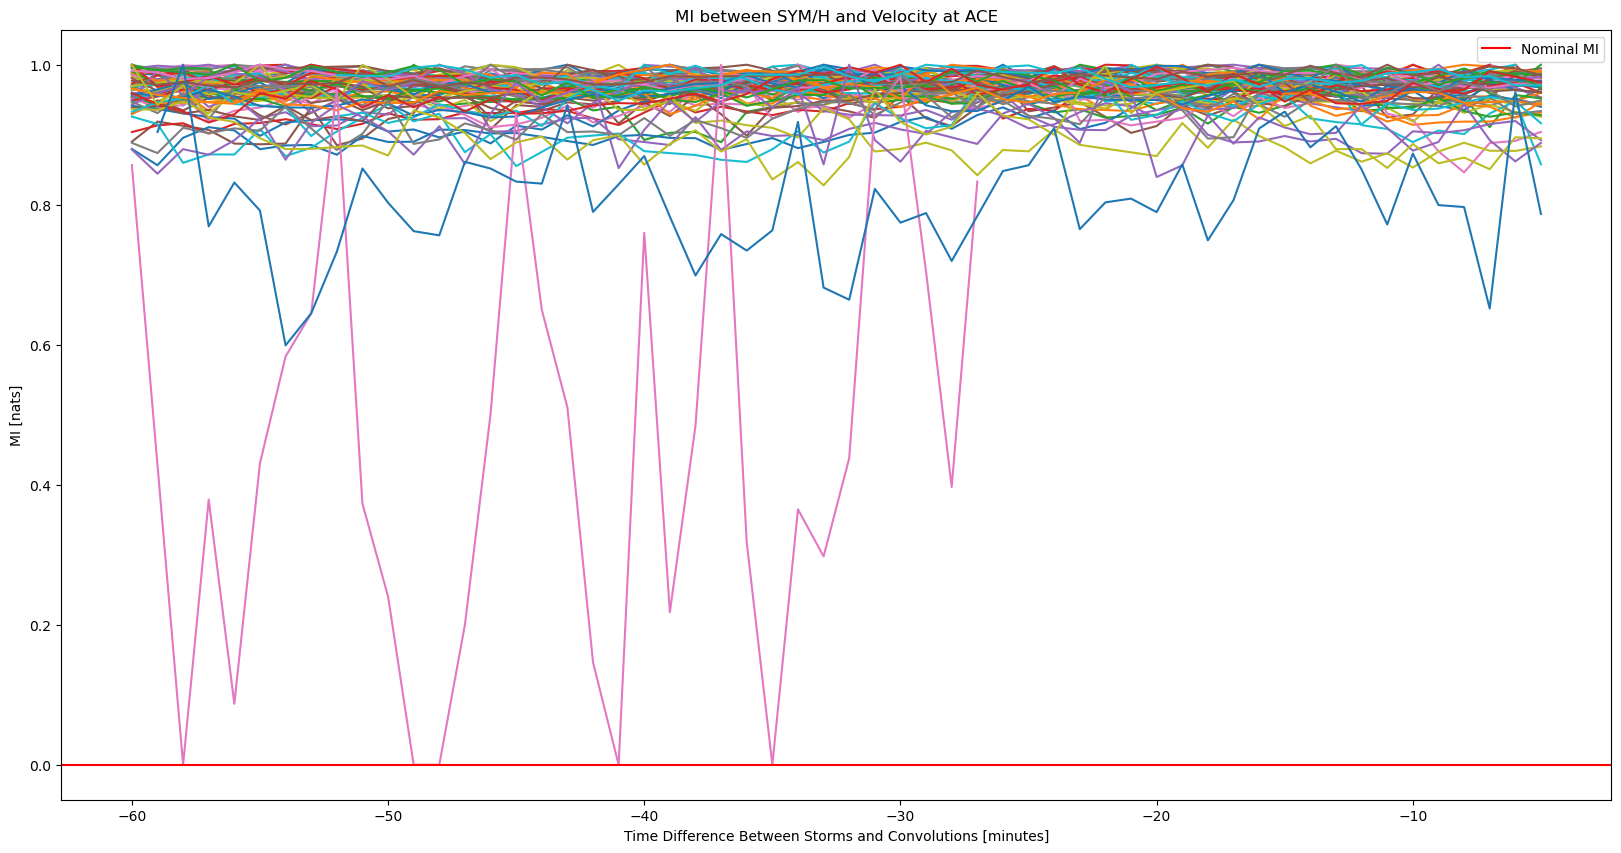

In [183]:
plt.figure(figsize=[20, 10])

omni_col_name = "SYM/H"
sw_col_name = "Velocity"
omni_col = omni_all_storms.columns.difference(["Datetime"], sort=False).get_loc(omni_col_name)
sw_col = level1_all_storms.columns.difference(["Datetime"], sort=False).get_loc(sw_col_name)
for i, storm in enumerate(storm_data):
    if not analysed1[i]:
        continue

    offset = i - sum(analysed1[:i])
    matrices_times = all_matrix_times1[i - offset]
    if (storm["Datetime"].max()-matrices_times.min()).total_seconds()/60 < 30:
        continue
    MI_matrices = all_storm_MI_matrices1[i - offset]

    max_MI_pos = np.argmax(MI_matrices[:, omni_col, sw_col])
    max_MI = MI_matrices[max_MI_pos, omni_col, sw_col]
    max_MI_time_delta = (matrices_times[max_MI_pos] - storm["Datetime"].max()).total_seconds()/60 # time of max MI relative to end of storm
    # plt.plot(max_MI_time_delta, max_MI, 'o', label = f"{i - offset + 1}")

    plt.plot(
        (pd.Series(all_matrix_times1[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60,
        MI_matrices[:, omni_col, sw_col]/max_MI,
        # label = f"{max_MI:.2f} at {max_MI_time_delta:.0f} minutes"
        )

# nominal MI
nominal_MI = (MI(
    omni_all_storms.sample(len(level1_all_storms[sw_col_name].dropna()))[omni_col_name],
    level1_all_storms[sw_col_name].dropna(),
    knn=True)[0])

plt.title(f'MI between {omni_col_name} and {sw_col_name} at ACE')
plt.xlabel('Time Difference Between Storms and Convolutions [minutes]')
plt.axhline(nominal_MI, label="Nominal MI", color='r')
plt.ylabel('MI [nats]')
plt.legend()
plt.show()

# time = []
# for i, storm in enumerate(storm_data):
#     if not analysed1[i]:
#         continue

#     offset = i - sum(analysed1[:i])
#     matrices_times = all_matrix_times1[i - offset]
#     if (storm["Datetime"].max()-matrices_times.min()).total_seconds()/60 < 30:
#         continue
#     MI_matrices = all_storm_MI_matrices1[i - offset]

#     max_MI_pos = np.argmax(MI_matrices[:, omni_col, sw_col])
#     max_MI_time_delta = (matrices_times[max_MI_pos] - storm["Datetime"].max()).total_seconds()/60 # time of max MI relative to end of storm
#     time.append(max_MI_time_delta)
# plt.title(f'Histogram of Peak MI Timings between {omni_col_name} and {sw_col_name} at ACE (Level 1 Data)')
# plt.ylabel('Frequency')
# plt.hist(time, bins=60)
# plt.show()

c:\Users\Aarnav\.conda\envs\UROP2024\Lib\site-packages\numpy\lib\nanfunctions.py:1746: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr, where=where)


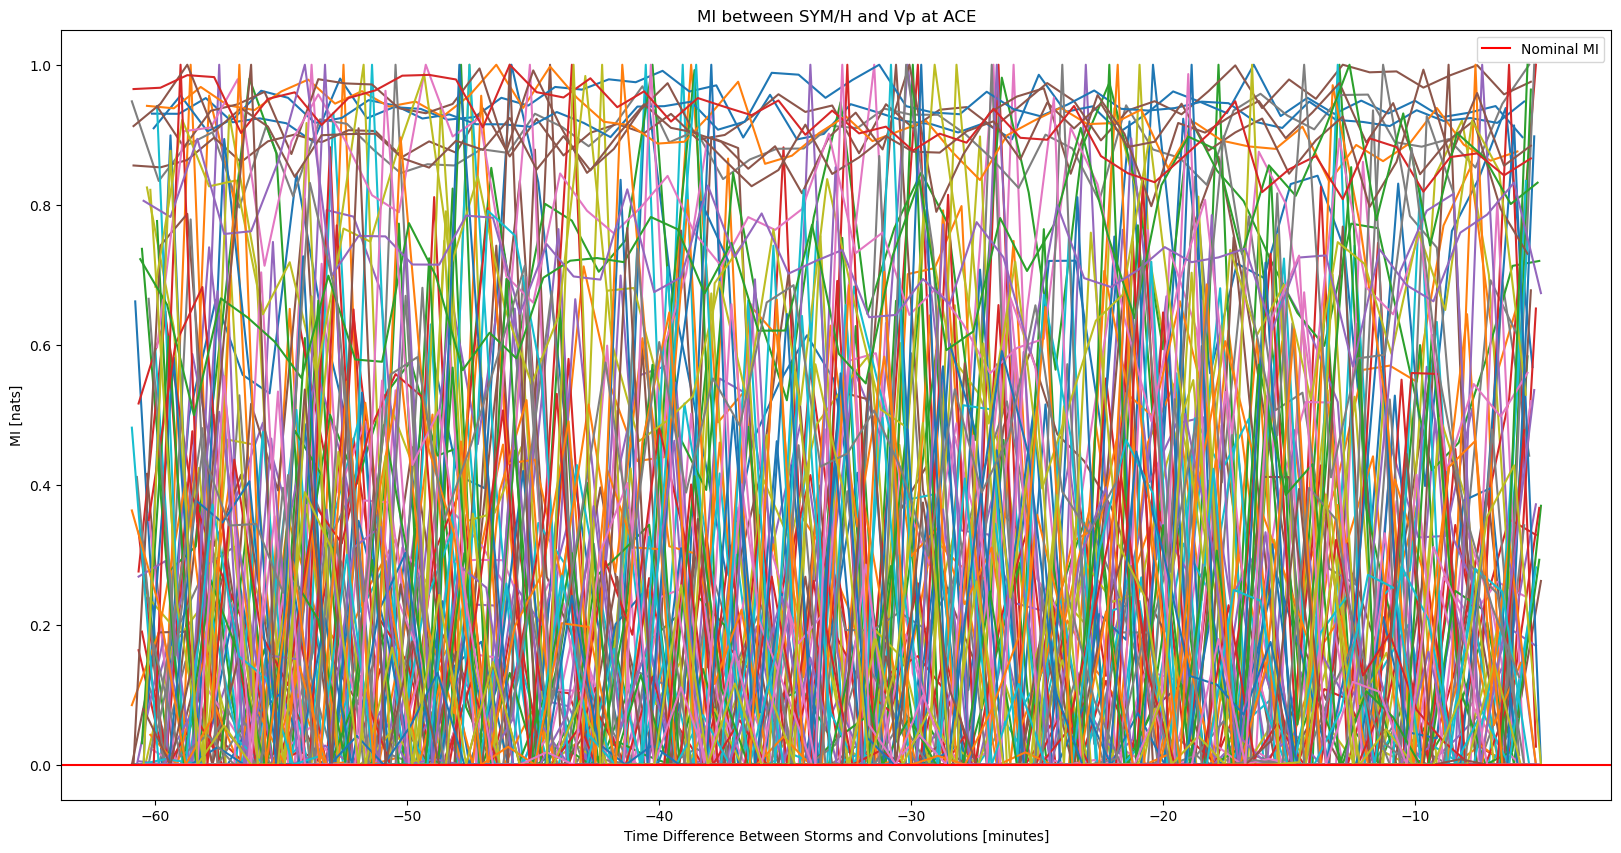

In [187]:
plt.figure(figsize=[20, 10])

omni_col_name = "SYM/H"
sw_col_name = "Vp"
omni_col = omni_all_storms.columns.difference(["Datetime"], sort=False).get_loc(omni_col_name)
sw_col = level2_all_storms.columns.difference(["Datetime"], sort=False).get_loc(sw_col_name)
for i, storm in enumerate(storm_data):
    if not analysed2[i]:
        continue

    offset = i - sum(analysed2[:i])
    matrices_times = all_matrix_times2[i - offset]
    if (storm["Datetime"].max()-matrices_times.min()).total_seconds()/60 < 30:
        continue
    MI_matrices = all_storm_MI_matrices2[i - offset]

    max_MI_pos = np.argmax(MI_matrices[:, omni_col, sw_col])
    max_MI = MI_matrices[max_MI_pos, omni_col, sw_col]
    max_MI_time_delta = (matrices_times[max_MI_pos] - storm["Datetime"].max()).total_seconds()/60 # time of max MI relative to end of storm
    # plt.plot(max_MI_time_delta, max_MI, 'o', label = f"{i - offset + 1}")

    plt.plot(
        (pd.Series(all_matrix_times2[i - offset]) - storm["Datetime"].max()).dt.total_seconds()/60,
        MI_matrices[:, omni_col, sw_col]/max_MI,
        # label = f"{max_MI:.2f} at {max_MI_time_delta:.0f} minutes"
        )
# nominal MI
nominal_MI = (MI(
    omni_all_storms.sample(len(level2_all_storms[sw_col_name]))[omni_col_name],
    level2_all_storms[sw_col_name],
    knn=True)[0])

plt.title(f'MI between {omni_col_name} and {sw_col_name} at ACE')
plt.xlabel('Time Difference Between Storms and Convolutions [minutes]')
plt.axhline(nominal_MI, label="Nominal MI", color='r')
plt.ylabel('MI [nats]')
plt.legend()
plt.show()

# time = []
# for i, storm in enumerate(storm_data):
#     if not analysed1[i]:
#         continue

#     offset = i - sum(analysed1[:i])
#     matrices_times = all_matrix_times1[i - offset]
#     if (storm["Datetime"].max()-matrices_times.min()).total_seconds()/60 < 30:
#         continue
#     MI_matrices = all_storm_MI_matrices1[i - offset]

#     max_MI_pos = np.argmax(MI_matrices[:, omni_col, sw_col])
#     max_MI_time_delta = (matrices_times[max_MI_pos] - storm["Datetime"].max()).total_seconds()/60 # time of max MI relative to end of storm
#     time.append(max_MI_time_delta)
# plt.title(f'Histogram of Peak MI Timings between {omni_col_name} and {sw_col_name} at ACE (Level 2 Data)')
# plt.ylabel('Frequency')
# plt.hist(time, bins=60)
# plt.show()

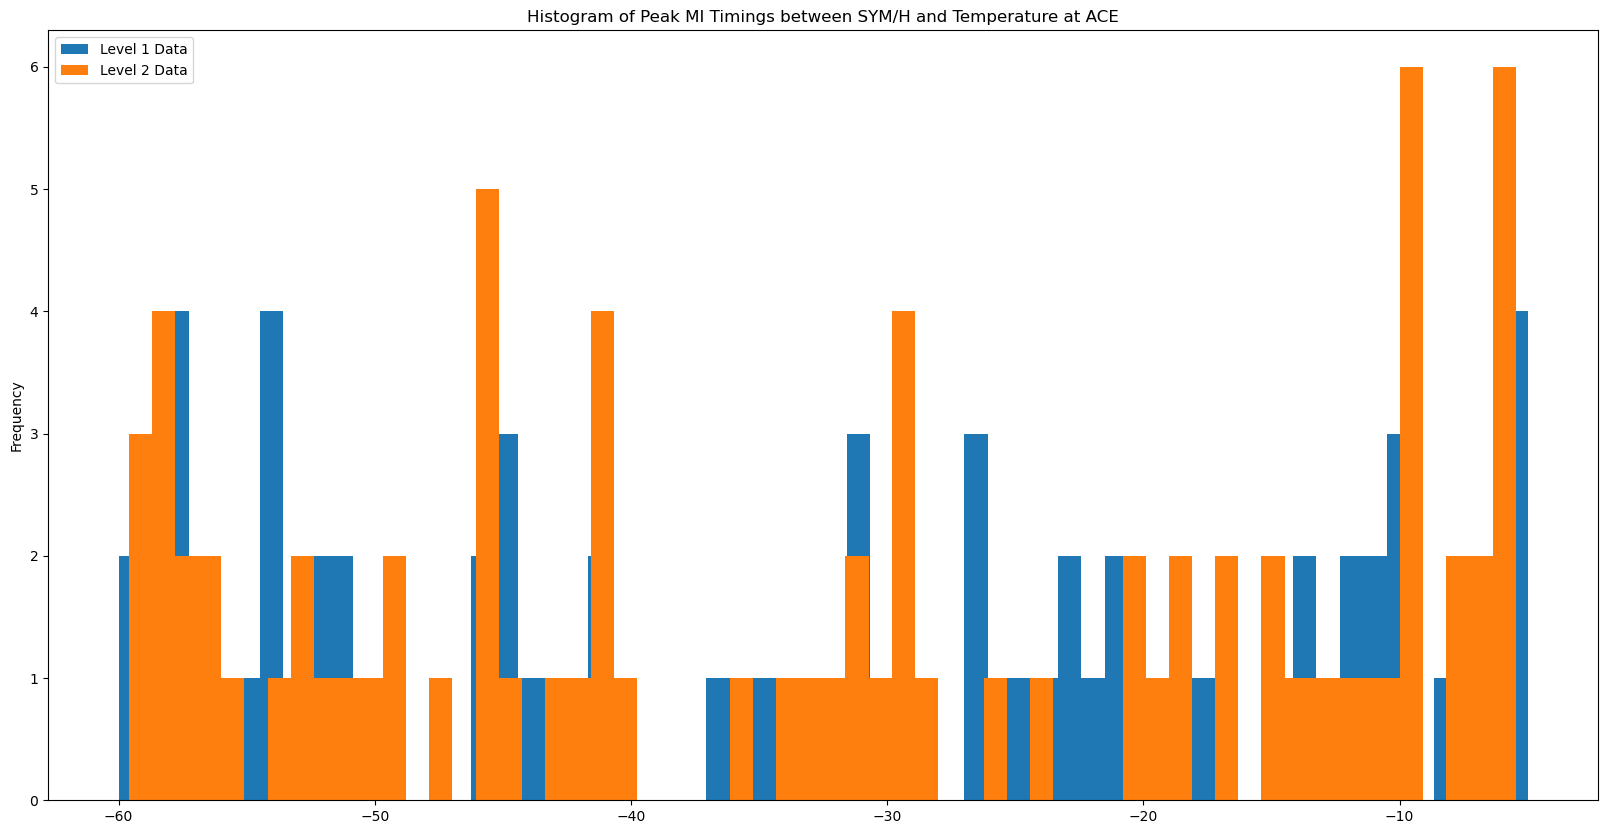

In [150]:
plt.figure(figsize=[20, 10])

omni_col_name = "SYM/H"
sw_col1_name = "Temperature"
sw_col2_name = "Tpr"

omni_col = omni_all_storms.columns.difference(["Datetime"], sort=False).get_loc(omni_col_name)
sw_col1 = level1_all_storms.columns.difference(["Datetime"], sort=False).get_loc(sw_col1_name)
sw_col2 = level2_all_storms.columns.difference(["Datetime"], sort=False).get_loc(sw_col2_name)

time1 = []
time2 = []
for i, storm in enumerate(storm_data):
    if analysed1[i]:
        offset = i - sum(analysed1[:i])
        matrices_times = all_matrix_times1[i - offset]
        if (storm["Datetime"].max()-matrices_times.min()).total_seconds()/60 < 30:
            continue
        MI_matrices = all_storm_MI_matrices1[i - offset]

        max_MI_pos = np.argmax(MI_matrices[:, omni_col, sw_col])
        max_MI_time_delta = (matrices_times[max_MI_pos] - storm["Datetime"].max()).total_seconds()/60 # time of max MI relative to end of storm
        time1.append(max_MI_time_delta)
    if analysed2[i]:
        offset = i - sum(analysed2[:i])
        matrices_times = all_matrix_times2[i - offset]
        if (storm["Datetime"].max()-matrices_times.min()).total_seconds()/60 < 30:
            continue
        MI_matrices = all_storm_MI_matrices2[i - offset]

        max_MI_pos = np.argmax(MI_matrices[:, omni_col, sw_col])
        max_MI_time_delta = (matrices_times[max_MI_pos] - storm["Datetime"].max()).total_seconds()/60
        time2.append(max_MI_time_delta)
    else:
        continue

plt.title(f'Histogram of Peak MI Timings between {omni_col_name} and {sw_col1_name} at ACE')
plt.ylabel('Frequency')
plt.hist(time1, bins=60, label="Level 1 Data")
plt.hist(time2, bins=60, label="Level 2 Data")
plt.legend()
plt.show()